## Import modules and functions

In [4]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

## Specify experiment directory

In [5]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/03_Collab/2020_Clara/All files/N1_HPN20DIV/SYT1/Calreticulin'
protein="TNR" #TNR,Agg,WFA,HABP

## Make dictionary for results and load aligned images from Matlab GUI

In [11]:
#make synapse results dictionary

spots={"filename":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if filelist[i].endswith(".txt"): 
        if ("rerun" in str(filelist[i]))==True:
            if ("output_classification" in str(filelist[i]))==True:
                #if (protein in str(filelist[i]))==True:
                     if ("backup" in str(filelist[i]))==False:
                        #if str(filelist[i][:-12]) not in str(spots["filename"]):
                            spots["filename"].append(filelist[i])


synapses_results={"spots classification filename":[],
                "sted spot":[],
                "vglut spot":[],
                "dio spot":[],
                  "synapse spot":[],
                "sted spot aligned":[],
                  "sted spot aligned filename":[],
                "vglut spot aligned":[],
                   "vglut spot aligned filename":[],
                  "synapse spot aligned":[],
                   "synapse spot aligned filename":[],
                "dio spot aligned":[]}


num=0
for spot in range(0,len(spots["filename"])):
    num+=1
    print(spots["filename"][spot])
    firstpart='/'.join(spots["filename"][spot].split("/")[:-1])
    lastpart=spots["filename"][spot].split("classification")[-1]
    synapses_results["spots classification filename"].append(spots["filename"][spot])
    file2read=firstpart+'/output_sted_'+lastpart
    synapses_results["sted spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_'+lastpart
    synapses_results["vglut spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_'+lastpart
    synapses_results["dio spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    file2read=firstpart+'/output_sted_aligned_'+lastpart
    synapses_results["sted spot aligned filename"].append(file2read)
    synapses_results["sted spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    file2read=firstpart+'/output_homer_aligned_'+lastpart
    synapses_results["vglut spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    synapses_results["vglut spot aligned filename"].append(file2read)
    
    file2read=firstpart+'/output_synapse_aligned_'+lastpart
    synapses_results["synapse spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    synapses_results["synapse spot aligned filename"].append(file2read)
    
    file2read=firstpart+'/output_dio_aligned_'+lastpart
    synapses_results["dio spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))                 

/Volumes/ukps-all$/user/tdanko/Imaging/03_Collab/2020_Clara/All files/N1_HPN20DIV/SYT1/Calreticulin/output_classification1_10_rerun.txt


KeyboardInterrupt: 

In [13]:
synapses_results["synapse spot aligned"][0]

IndexError: list index out of range

In [3]:
#make synapse results dictionary

spots={"filename":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if filelist[i].endswith(".txt"): 
        if ("rerun" in str(filelist[i]))==True:
            if ("output_classification" in str(filelist[i]))==True:
                #if (protein in str(filelist[i]))==True:
                     if ("backup" in str(filelist[i]))==False:
                        #if str(filelist[i][:-12]) not in str(spots["filename"]):
                            spots["filename"].append(filelist[i])


synapses_results={"spots classification filename":[],
                "sted spot":[],
                "vglut spot":[],
                "dio spot":[],
                "sted spot aligned":[],
                  "sted spot aligned filename":[],
                "vglut spot aligned":[],
                   "vglut spot aligned filename":[],
                  "synapse spot aligned":[],
                   "synapse spot aligned filename":[],
                "dio spot aligned":[],
                 
                "Exp name":[],
                "Cell number":[],
                "unique id (expname_cell number)":[],
                "classification":[],
                  "mean ecm intensity sted":[],
                  "ecm intensity sted, bg subtracted":[],
                  "mean ecm intensity sted noback":[],
                  "ecm intensity sted noback bg subtracted":[],
                  "mean vglut intensity sted":[],
                  "vglut intensity sted, bg subtracted":[],
                  "mean vglut intensity sted noback":[],
                  "vglut intensity sted noback bg subtracted":[],
                  "mean vglut size (sum of pixels)":[],
                  "mean vglut size (sum of pixels) from noback":[],
                  "exp condition":[],
                 "dio intensity sted, bg subtracted":[]}
                  
num=0
for spot in range(0,len(spots["filename"])):
    num+=1
    print(spots["filename"][spot])
    firstpart='/'.join(spots["filename"][spot].split("/")[:-1])
    lastpart=spots["filename"][spot].split("classification")[-1]
    synapses_results["spots classification filename"].append(spots["filename"][spot])
    file2read=firstpart+'/output_sted_'+lastpart
    synapses_results["sted spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_'+lastpart
    synapses_results["vglut spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_'+lastpart
    synapses_results["dio spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    file2read=firstpart+'/output_sted_aligned_'+lastpart
    synapses_results["sted spot aligned filename"].append(file2read)
    synapses_results["sted spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    file2read=firstpart+'/output_homer_aligned_'+lastpart
    synapses_results["vglut spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    synapses_results["vglut spot aligned filename"].append(file2read)
    
    file2read=firstpart+'/output_homer_aligned_'+lastpart
    synapses_results["vglut spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    synapses_results["vglut spot aligned filename"].append(file2read)
    
    file2read=firstpart+'/output_dio_aligned_'+lastpart
    synapses_results["dio spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_noback_'+lastpart
    synapses_results["sted spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_noback_'+lastpart
    synapses_results["vglut spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_noback_'+lastpart
    synapses_results["dio spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    synapses_results["Exp name"].append(file2read.split("2019")[-1][0:4])
    synapses_results["Cell number"].append(lastpart[-9:-4])
    synapses_results["unique id (expname_cell number)"].append(file2read.split("2019")[-1][0:4]+'_'+lastpart[-9:-4])
    synapses_results["classification"].append(np.loadtxt(spots["filename"][spot]))
    synapses_results["exp condition"].append(synapses_results["spots classification filename"][spot].split("TIFs")[-1].split('/')[1])
    
    synapses_results["mean ecm intensity sted"].append(np.nan)
    
    synapses_results["ecm intensity sted, bg subtracted"].append(np.nan)
    
    synapses_results["mean ecm intensity sted noback"].append(np.nan)
    synapses_results["ecm intensity sted noback bg subtracted"].append(np.nan)
    
    synapses_results["mean vglut intensity sted"].append(np.nan)
    synapses_results["vglut intensity sted, bg subtracted"].append(np.nan)
    
    synapses_results["mean vglut intensity sted noback"].append(np.nan)
    synapses_results["vglut intensity sted noback bg subtracted"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels)"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels) from noback"].append(np.nan)
    
    synapses_results["dio intensity sted, bg subtracted"].append(np.nan)
    
clear_output() 

## Tot. no. synapses read

In [4]:
len(synapses_results["spots classification filename"])

3602

## Make dictionary for individual synapse (spot) images

In [5]:
for spotno in range(0,len(synapses_results["spots classification filename"])):
    synapses_results["mean ecm intensity sted"][spotno]=np.nanmean(synapses_results["sted spot aligned"][spotno])
    synapses_results["mean ecm intensity sted noback"][spotno]=np.nanmean(synapses_results["sted spot aligned no back"][spotno])
    synapses_results["mean vglut intensity sted"][spotno]=np.nanmean(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut intensity sted noback"][spotno]=np.nanmean(synapses_results["vglut spot aligned no back"][spotno])
    synapses_results["mean vglut size (sum of pixels)"][spotno]=np.sum(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut size (sum of pixels) from noback"][spotno]=np.sum(synapses_results["vglut spot aligned no back"][spotno])

    #bg subtraction
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["dio spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["dio intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)

## Make DF

In [6]:
df=pd.DataFrame(synapses_results)


df["mean ecm intensity sted, bg subtracted"]=np.nan
df["mean vglut intensity sted, bg subtracted"]=np.nan

df["sted spot aligned under dio"]=df["sted spot aligned"]
df["ecm intensity sted, bg subtracted under dio"]=df["ecm intensity sted, bg subtracted"]
df["vglut spot aligned under dio"]=df["vglut spot aligned"]
df["vglut intensity sted, bg subtracted under dio"]=df["vglut intensity sted, bg subtracted"]

df["mean ecm intensity sted under dio"]=np.nan
df["mean vglut intensity sted under dio"]=np.nan
df["mean ecm intensity sted, bg subtracted under dio"]=np.nan
df["mean vglut intensity sted, bg subtracted under dio"]=np.nan

df["dio size"]=np.nan

for i in range(0,len(df)):
    df["mean ecm intensity sted, bg subtracted"][i]=df["ecm intensity sted, bg subtracted"][i].mean()
    df["mean vglut intensity sted, bg subtracted"][i]=df["vglut intensity sted, bg subtracted"][i].mean()
    
    diomask=df["dio intensity sted, bg subtracted"][i]>0
    
    df["dio size"][i]=np.nansum(diomask)
    
    image=df["sted spot aligned under dio"][i]
    image[~diomask]=0
    df["sted spot aligned under dio"][i]=image 
    
    image=df["ecm intensity sted, bg subtracted"][i]
    image[~diomask]=0
    df["ecm intensity sted, bg subtracted under dio"][i]=image    
    
    image=df["vglut spot aligned under dio"][i]
    image[~diomask]=0
    df["vglut spot aligned under dio"][i]=image    
    
    image=df["vglut intensity sted, bg subtracted"][i]
    image[~diomask]=0
    df["vglut intensity sted, bg subtracted under dio"][i]=image
    
    df["mean ecm intensity sted under dio"][i]=df["sted spot aligned under dio"][i].mean()
    df["mean vglut intensity sted under dio"][i]=df["vglut spot aligned under dio"][i].mean()
    df["mean ecm intensity sted, bg subtracted under dio"][i]=df["ecm intensity sted, bg subtracted"][i].mean()
    df["mean vglut intensity sted, bg subtracted under dio"][i]=df["vglut intensity sted, bg subtracted under dio"][i].mean()

df2=deepcopy(df)
df2=df2.reset_index()

df2['Protein']='None'
df2.loc[df2['spots classification filename'].str.contains('TGN'), 'Protein'] = 'TGN38'
df2.loc[df2['spots classification filename'].str.contains('alreticulin'), 'Protein'] = 'Calreticulin'
df2.loc[df2["spots classification filename"].str.contains('Synaptopodin'), 'Protein'] = 'Synaptopodin'
df2.loc[df2["spots classification filename"].str.contains('ERGIC'), 'Protein'] = 'ERGIC'

df2['Exp']='None'
df2.loc[df2['spots classification filename'].str.contains('N2_'), 'Exp'] = 'N2'
df2.loc[df2['spots classification filename'].str.contains('N1_'), 'Exp'] = 'N1'
df2.loc[df2['spots classification filename'].str.contains('N0_'), 'Exp'] = 'N0'
df2.loc[df2['spots classification filename'].str.contains('N3_'), 'Exp'] = 'N3'
df2.loc[df2['spots classification filename'].str.contains('N4_'), 'Exp'] = 'N4'

df2.loc[df2['spots classification filename'].str.contains('Other Data'), 'Exp'] = 'Other Data'
df2.loc[df2['spots classification filename'].str.contains('BIN'), 'Exp'] = 'BIN'

df2["Classification"]="none"
df2.loc[df2["classification"]==1.0,"Classification"]="Mushroom"
df2.loc[df2["classification"]==2.0,"Classification"]="Flat"
df2.loc[df2["classification"]==3.0,"Classification"]="Bouton"

dfbackup=deepcopy(df2)

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning

In [32]:
df2=df2[df2["Exp"]!="N0"]
df2=df2.reset_index(drop=True)

## Add intensity normalized by median

In [33]:
expnam=[]
medprot=[]
medvglut=[]
for exp in df2["Exp"].unique():
    dfexp=df2[df2["Exp"]==exp]
    med_prot=dfexp["mean ecm intensity sted, bg subtracted under dio"].median()
    med_vglut=dfexp["mean vglut intensity sted, bg subtracted under dio"].median()
    print(exp+' - med prot: '+str(med_prot)+' - med vglut: '+str(med_vglut))
    expnam.append(exp)
    medprot.append(med_prot)
    medvglut.append(med_vglut)
df2["ecm mean int norm2med"]=np.nan
df2["vglut mean int norm2med"]=np.nan
for i in range(0,len(df2)):
    for j in range(0,len(expnam)):
        if df2["Exp"][i]==expnam[j]:
            df2["ecm mean int norm2med"][i]=df2["mean ecm intensity sted, bg subtracted under dio"][i]/medprot[j]
            df2["vglut mean int norm2med"][i]=df2["mean vglut intensity sted, bg subtracted under dio"][i]/medvglut[j]
        

N1 - med prot: 0.16156329938430872 - med vglut: 7.871357323859087
N4 - med prot: 0.38282678942704595 - med vglut: 5.522307860570962
N2 - med prot: 0.25482941582768825 - med vglut: 7.683459369361692


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Show random image

Text(0.5, 1.0, 'dio around synapse spot')

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


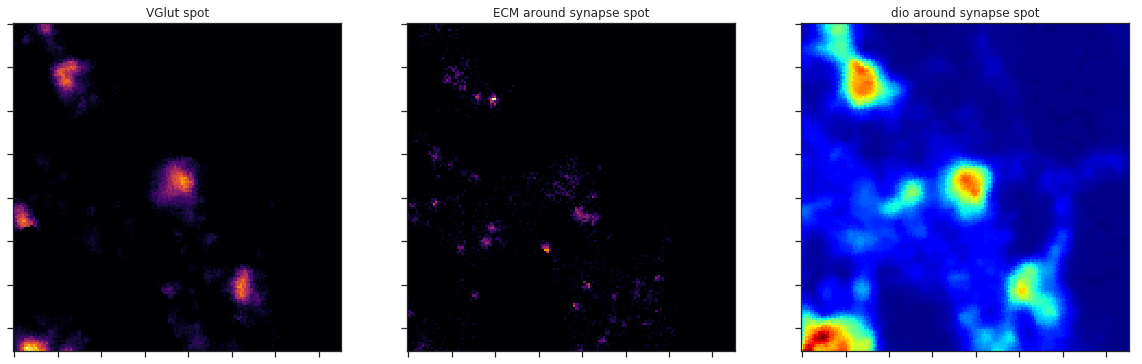

In [34]:
randomno=np.random.randint(1,len(df2))
fig=plt.figure(figsize=(20,20))
fig.add_subplot(131)
plt.imshow(df2["vglut intensity sted, bg subtracted"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('VGlut spot')
fig.add_subplot(132)
plt.imshow(df2["ecm intensity sted, bg subtracted"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('ECM around synapse spot')
fig.add_subplot(133)
plt.imshow(df2["dio spot aligned"][randomno],cmap='jet')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('dio around synapse spot')

## Remove outliers

In [10]:
vari="mean ecm intensity sted, bg subtracted under dio"
df2=df2[df2[vari]<df2[vari].quantile(.99)]

In [91]:
protein="TGN38"

## ttests

In [132]:
#vari='mean ecm intensity sted, bg subtracted under dio'
vari="ecm mean int norm2med"
df2protein=df2[df2["Protein"]==protein]

mush=df2protein[df2protein["Classification"]=="Mushroom"][vari].dropna().values
flat=df2protein[df2protein["Classification"]=="Flat"][vari].dropna().values

[stat,pval_1]=stats.ttest_ind(mush, flat)

print(mush.mean())
print(flat.mean())
print(pval_1)


2.5463769050888216
2.361802114600155
0.41631569886977215


## Plots

## Plot unblocked

In [76]:
vari

'ecm mean int norm2med'

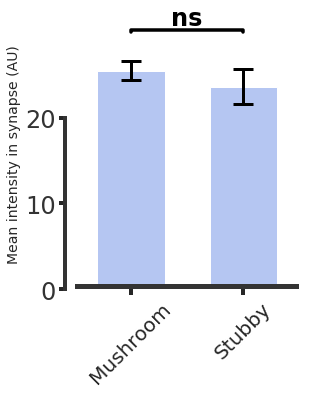

In [133]:
vari="ecm mean int norm2med"
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker
plt.rcParams['font.sans-serif'] = 'Helvetica'

df2plot=df2protein

fig=plt.figure(figsize=(4,5))
palette={"All, mushroom": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}

order=["Mushroom","Flat"]

g=sns.barplot(data=df2plot,y=vari,x="Classification"
            ,order=order,color="#abc2fc",ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .6)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Classification"]==condtype][vari].mean() for condtype in order],
             yerr=[df2plot[df2plot["Classification"]==condtype][vari].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

#plt.ylim([0,1.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)

scale_y=1/10
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
g.yaxis.set_major_formatter(ticks_y)
#plt.yticks([0,.5,1,1.5],color='#333333')
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('Mean intensity in synapse (AU)',size=14)
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),['Mushroom','Stubby'],
           rotation=45,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)


x1, x2 = 0,1
y= 3
h=0.02
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_postsynpasesdio_mushstubby_alleps.svg', bbox_inches='tight', format='svg')

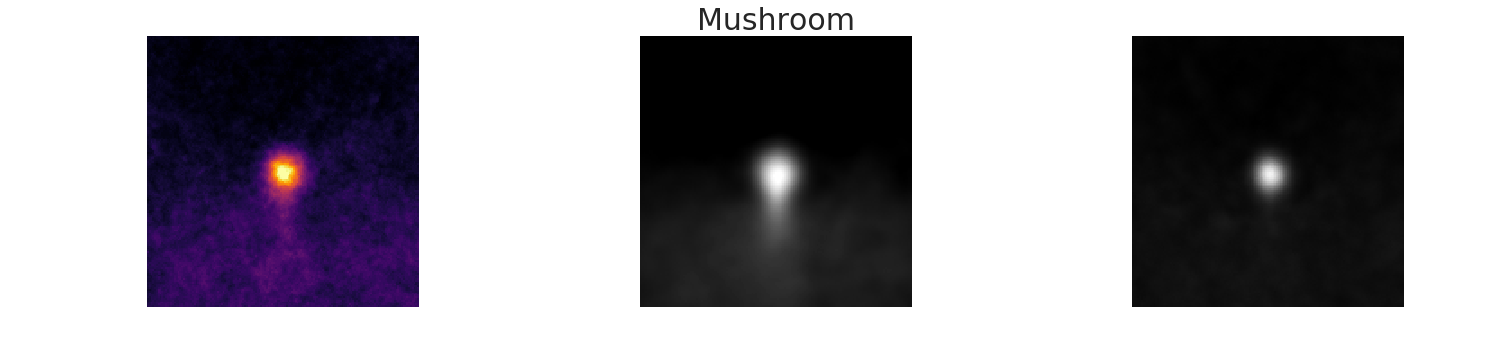

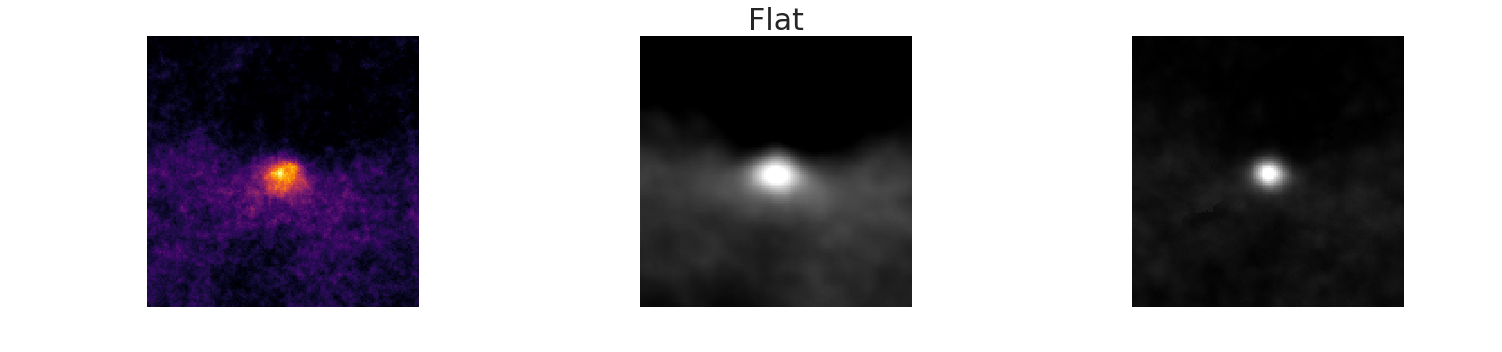

In [134]:
var="ecm intensity sted, bg subtracted under dio"
#var=vari
homer= 'vglut intensity sted, bg subtracted under dio'
#homer="vglut mean int norm2med"

for classi in ["Mushroom","Flat"]:
    df2protein_class=df2protein[df2protein["Classification"]==classi]
    fig=plt.figure(figsize=(25,5))
    plt.title(classi)
    plt.axis('off')
    #plt.title(str(i))
    fig.add_subplot(131)
    plt.imshow(df2protein_class[var].mean()
               ,cmap='inferno',
               vmin=2*df2protein[var].mean().min(),
               vmax=0.9*np.max(df2protein[var].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    #plt.gca().add_artist(scalebar)
    plt.axis('off')
    data=df2protein_class[var].mean()
    im = Image.fromarray(data)
    #im.save(diri+'figure2_mushrooms_unblocked_sted.tiff')

    fig.add_subplot(132)
    plt.imshow(df2protein_class["dio spot aligned"].mean()
               ,cmap='gray',
               vmin=1.0009*np.min(df2protein["dio spot aligned"].mean()),
               vmax=.9999*np.max(df2protein["dio spot aligned"].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    #plt.gca().add_artist(scalebar)
    plt.axis('off')
    data=df2protein_class["dio spot aligned"].mean()
    im = Image.fromarray(data)
    #im.save(diri+'figure2_mushrooms_unblocked_dio.tiff')

    fig.add_subplot(133)
    plt.imshow(df2protein_class[homer].mean()
               ,cmap='gray',
               vmin=1.0009*np.min(df2protein[homer].mean()),
               vmax=.9999*np.max(df2protein[homer].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    #plt.gca().add_artist(scalebar)
    plt.axis('off')
    data=df2protein_class["dio spot aligned"].mean()
    im = Image.fromarray(data)
    #im.save(diri+'figure2_mushrooms_unblocked_dio.tiff')

## Check correlation to size - all

In [85]:
##sort df according to synapse intensity
df3=deepcopy(df2protein[df2protein["Exp"]!="N0"])
df3=df3.sort_values("dio size",ascending=True)
df3=df3.reset_index(drop=True)
#split into 5 separate dfs, add column with number
a, b, c,d,e = np.split(df3, [int(.2*len(df3)),int(.4*len(df3)),int(.6*len(df3)),int(.8*len(df3))])
a['Synapse mean size ordinal bin']=0
b['Synapse mean size ordinal bin']=1
c['Synapse mean size ordinal bin']=2
d['Synapse mean size ordinal bin']=3
e['Synapse mean size ordinal bin']=4
#combine split dfs into one
dfnew=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)

## plot corr2size new epitopes

In [140]:
synapse_bin_type='Synapse mean size ordinal bin'
means_in_bins_exps={"Exp name":[],"bin number":[],"mean tnr":[],"number of spots":[],
                    "mean size int in bin overall":[]}
for exp in dfnew["Exp"].unique():
    dfexp=dfnew[dfnew["Exp"]==exp]
    for i in range(0,5):       
        mean_in_bin=dfnew[dfnew[synapse_bin_type].astype(int)==i]["dio size"].mean()
        dfplot=dfexp[(dfexp[synapse_bin_type].astype(int)==i)]
        means_in_bins_exps["Exp name"].append(exp)
        means_in_bins_exps["bin number"].append(i)
        means_in_bins_exps["mean size int in bin overall"].append(mean_in_bin)
        means_in_bins_exps["mean tnr"].append(dfplot[vari].mean())
        nosynapses=len(dfplot)
        means_in_bins_exps["number of spots"].append(nosynapses)
dfmeans=pd.DataFrame(means_in_bins_exps)
dfmeans["mean size int in bin overall"]=np.around(dfmeans["mean size int in bin overall"],1)
dfmeans["mean size int in bin overall micronsq"]=(dfmeans["mean size int in bin overall"]*.0004)

In [141]:
dfmeans

,Exp name,bin number,mean tnr,number of spots,mean size int in bin overall,mean size int in bin overall micronsq
0,N4,0,3.233530,83,6115.8,2.44632
1,N4,1,3.611710,64,7047.9,2.81916
2,N4,2,3.764768,59,7687.1,3.07484
3,N4,3,3.978924,52,8276.0,3.31040
4,N4,4,4.430578,35,9110.0,3.64400
5,N2,0,0.662089,10,6115.8,2.44632
6,N2,1,0.772853,18,7047.9,2.81916
7,N2,2,0.879459,17,7687.1,3.07484
8,N2,3,1.009163,24,8276.0,3.31040
9,N2,4,1.247827,18,9110.0,3.64400


<Figure size 432x288 with 0 Axes>

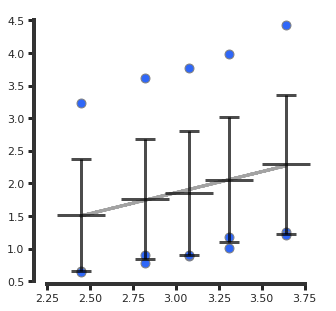

In [142]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"
fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean size int in bin overall micronsq",y="mean tnr",
                data=dfmeans,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=[dfmeans[dfmeans["bin number"]==0][var].sem(),
                   dfmeans[dfmeans["bin number"]==1][var].sem(),
                   dfmeans[dfmeans["bin number"]==2][var].sem(),
                   dfmeans[dfmeans["bin number"]==3][var].sem(),
                   dfmeans[dfmeans["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


plt.rcParams['font.sans-serif'] = 'Helvetica'
g.grid(False)
#plt.ylim([0.6,1.41])
#plt.xlim([0.3,2.2])

#fit linear curve
x=dfmeans["mean size int in bin overall micronsq"]
y=dfmeans["mean tnr"]
m,b = np.polyfit(x, y, 1) 
plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 


#change pixel count to nm2
#scale_x=1/.4
#ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
#g.xaxis.set_major_formatter(ticks_x)


#formatting
g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":False,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('')
#plt.yticks([0.2,0.4,0.6,0.8,1],color='#333333',size=20)
#plt.xticks([0.5,1.4,2,2.7,4],color='#333333',size=20,rotation=45)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_tnrsizecorr.svg', bbox_inches='tight', format='svg')

In [143]:
from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(dfmeans["mean tnr"],dfmeans["mean size int in bin overall"])
print(str(pearson**2))
print(pval)

0.0365450020834388
0.49492699065853485


## corr2size mushrooms

In [144]:
vari

'ecm mean int norm2med'

In [151]:
vari="ecm mean int norm2med"

0.0365450020834388
0.49492699065853485


<Figure size 432x288 with 0 Axes>

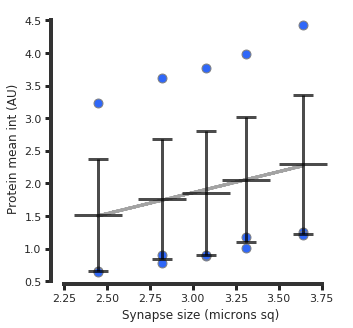

In [152]:
##sort df according to synapse intensity
df3=deepcopy(df2protein[df2protein["Classification"]=="Mushroom"])
df3=df3.sort_values("dio size",ascending=True)
df3=df3.reset_index(drop=True)
#split into 5 separate dfs, add column with number
a, b, c,d,e = np.split(df3, [int(.2*len(df3)),int(.4*len(df3)),int(.6*len(df3)),int(.8*len(df3))])
a['Synapse mean size ordinal bin']=0
b['Synapse mean size ordinal bin']=1
c['Synapse mean size ordinal bin']=2
d['Synapse mean size ordinal bin']=3
e['Synapse mean size ordinal bin']=4
#combine split dfs into one
dfnew=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)

synapse_bin_type='Synapse mean size ordinal bin'
means_in_bins_exps={"Exp name":[],"bin number":[],"mean tnr":[],"number of spots":[],
                    "mean size int in bin overall":[]}
for exp in dfnew["Exp"].unique():
    dfexp=dfnew[dfnew["Exp"]==exp]
    for i in range(0,5):       
        mean_in_bin=dfnew[dfnew[synapse_bin_type].astype(int)==i]["dio size"].mean()
        dfplot=dfexp[(dfexp[synapse_bin_type].astype(int)==i)]
        means_in_bins_exps["Exp name"].append(exp)
        means_in_bins_exps["bin number"].append(i)
        means_in_bins_exps["mean size int in bin overall"].append(mean_in_bin)
        means_in_bins_exps["mean tnr"].append(dfplot[vari].mean())
        nosynapses=len(dfplot)
        means_in_bins_exps["number of spots"].append(nosynapses)
dfmeans=pd.DataFrame(means_in_bins_exps)
dfmeans["mean size int in bin overall"]=np.around(dfmeans["mean size int in bin overall"],1)
dfmeans["mean size int in bin overall micronsq"]=(dfmeans["mean size int in bin overall"]*.0004)

sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"
fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean size int in bin overall micronsq",y="mean tnr",
                data=dfmeans,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=[dfmeans[dfmeans["bin number"]==0][var].sem(),
                   dfmeans[dfmeans["bin number"]==1][var].sem(),
                   dfmeans[dfmeans["bin number"]==2][var].sem(),
                   dfmeans[dfmeans["bin number"]==3][var].sem(),
                   dfmeans[dfmeans["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


plt.rcParams['font.sans-serif'] = 'Helvetica'
g.grid(False)
#plt.ylim([0.6,1.41])
#plt.xlim([0.3,2.2])

#fit linear curve
x=dfmeans["mean size int in bin overall micronsq"]
y=dfmeans["mean tnr"]
m,b = np.polyfit(x, y, 1) 
plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 


#change pixel count to nm2
#scale_x=1/.4
#ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
#g.xaxis.set_major_formatter(ticks_x)


#formatting
g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":False,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
g.set_ylabel('Protein mean int (AU)')
g.set_xlabel('Synapse size (microns sq)')
#plt.yticks([0.2,0.4,0.6,0.8,1],color='#333333',size=20)
#plt.xticks([0.5,1.4,2,2.7,4],color='#333333',size=20,rotation=45)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_tnrsizecorr.svg', bbox_inches='tight', format='svg')

from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(dfmeans["mean tnr"],dfmeans["mean size int in bin overall"])
print(str(pearson**2))
print(pval)

## corr2size flats

0.08009941213306786
0.306721089758847


<Figure size 432x288 with 0 Axes>

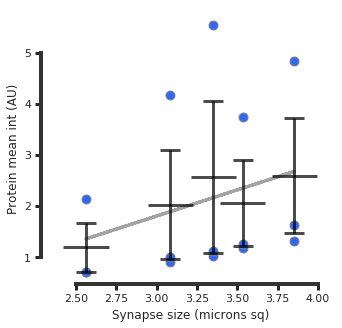

In [147]:
##sort df according to synapse intensity
df3=deepcopy(df2protein[df2protein["Classification"]=="Flat"])
df3=df3.sort_values("dio size",ascending=True)
df3=df3.reset_index(drop=True)
#split into 5 separate dfs, add column with number
a, b, c,d,e = np.split(df3, [int(.2*len(df3)),int(.4*len(df3)),int(.6*len(df3)),int(.8*len(df3))])
a['Synapse mean size ordinal bin']=0
b['Synapse mean size ordinal bin']=1
c['Synapse mean size ordinal bin']=2
d['Synapse mean size ordinal bin']=3
e['Synapse mean size ordinal bin']=4
#combine split dfs into one
dfnew=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)

synapse_bin_type='Synapse mean size ordinal bin'
means_in_bins_exps={"Exp name":[],"bin number":[],"mean tnr":[],"number of spots":[],
                    "mean size int in bin overall":[]}
for exp in dfnew["Exp"].unique():
    dfexp=dfnew[dfnew["Exp"]==exp]
    for i in range(0,5):       
        mean_in_bin=dfnew[dfnew[synapse_bin_type].astype(int)==i]["dio size"].mean()
        dfplot=dfexp[(dfexp[synapse_bin_type].astype(int)==i)]
        means_in_bins_exps["Exp name"].append(exp)
        means_in_bins_exps["bin number"].append(i)
        means_in_bins_exps["mean size int in bin overall"].append(mean_in_bin)
        means_in_bins_exps["mean tnr"].append(dfplot[vari].mean())
        nosynapses=len(dfplot)
        means_in_bins_exps["number of spots"].append(nosynapses)
dfmeans=pd.DataFrame(means_in_bins_exps)
dfmeans["mean size int in bin overall"]=np.around(dfmeans["mean size int in bin overall"],1)
dfmeans["mean size int in bin overall micronsq"]=(dfmeans["mean size int in bin overall"]*.0004)

sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"
fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean size int in bin overall micronsq",y="mean tnr",
                data=dfmeans,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=[dfmeans[dfmeans["bin number"]==0][var].sem(),
                   dfmeans[dfmeans["bin number"]==1][var].sem(),
                   dfmeans[dfmeans["bin number"]==2][var].sem(),
                   dfmeans[dfmeans["bin number"]==3][var].sem(),
                   dfmeans[dfmeans["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


plt.rcParams['font.sans-serif'] = 'Helvetica'
g.grid(False)
#plt.ylim([0.6,1.41])
#plt.xlim([0.3,2.2])

#fit linear curve
x=dfmeans["mean size int in bin overall micronsq"]
y=dfmeans["mean tnr"]
m,b = np.polyfit(x, y, 1) 
plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 


#change pixel count to nm2
#scale_x=1/.4
#ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
#g.xaxis.set_major_formatter(ticks_x)


#formatting
g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":False,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
g.set_ylabel('Protein mean int (AU)')
g.set_xlabel('Synapse size (microns sq)')
#plt.yticks([0.2,0.4,0.6,0.8,1],color='#333333',size=20)
#plt.xticks([0.5,1.4,2,2.7,4],color='#333333',size=20,rotation=45)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_tnrsizecorr.svg', bbox_inches='tight', format='svg')

from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(dfmeans["mean tnr"],dfmeans["mean size int in bin overall"])
print(str(pearson**2))
print(pval)

## Distribution analyses

- Read icy binary tif files
- for each spot: 
    - calculate mean distance between nearest neighbours
    - calculate mean distance between nearest neighbours weighted by intensity
    - calculate mean distance from nearest homer spot
    - calculate mean distance from nearest homer spot weighted by intensity

In [19]:
df2=df2.reset_index(drop=True)

## Make tifs for icy spots

In [313]:
import shutil
for spot in range(0,len(df2)):
    print(str(spot+1)+' out of ' + str(len(df2)))
    
    #shutil.copy2(df2["sted spot aligned filename"][spot], df2["sted spot aligned filename"][spot]+'_icy.tif')
    #shutil.os.remove(df2["sted spot aligned filename"][spot]+'_icy.tif')
    
    data=df2["ecm intensity sted, bg subtracted under dio"][spot]
    data=np.asarray(data,dtype=np.uint16)
    im = Image.fromarray(data)
    im.save(df2["sted spot aligned filename"][spot]+'_icy.tif')
    
    data=df2["vglut intensity sted, bg subtracted under dio"][spot]
    data=np.asarray(data,dtype=np.uint16)
    im = Image.fromarray(data)
    im.save(df2["vglut spot aligned filename"][spot]+'_icy.tif')

1 out of 3564
2 out of 3564
3 out of 3564
4 out of 3564
5 out of 3564
6 out of 3564
7 out of 3564
8 out of 3564
9 out of 3564
10 out of 3564
11 out of 3564
12 out of 3564
13 out of 3564
14 out of 3564
15 out of 3564
16 out of 3564
17 out of 3564
18 out of 3564
19 out of 3564
20 out of 3564
21 out of 3564
22 out of 3564
23 out of 3564
24 out of 3564
25 out of 3564
26 out of 3564
27 out of 3564
28 out of 3564
29 out of 3564
30 out of 3564
31 out of 3564
32 out of 3564
33 out of 3564
34 out of 3564
35 out of 3564
36 out of 3564
37 out of 3564
38 out of 3564
39 out of 3564
40 out of 3564
41 out of 3564
42 out of 3564
43 out of 3564
44 out of 3564
45 out of 3564
46 out of 3564
47 out of 3564
48 out of 3564
49 out of 3564
50 out of 3564
51 out of 3564
52 out of 3564
53 out of 3564
54 out of 3564
55 out of 3564
56 out of 3564
57 out of 3564
58 out of 3564
59 out of 3564
60 out of 3564
61 out of 3564
62 out of 3564
63 out of 3564
64 out of 3564
65 out of 3564
66 out of 3564
67 out of 3564
68 o

520 out of 3564
521 out of 3564
522 out of 3564
523 out of 3564
524 out of 3564
525 out of 3564
526 out of 3564
527 out of 3564
528 out of 3564
529 out of 3564
530 out of 3564
531 out of 3564
532 out of 3564
533 out of 3564
534 out of 3564
535 out of 3564
536 out of 3564
537 out of 3564
538 out of 3564
539 out of 3564
540 out of 3564
541 out of 3564
542 out of 3564
543 out of 3564
544 out of 3564
545 out of 3564
546 out of 3564
547 out of 3564
548 out of 3564
549 out of 3564
550 out of 3564
551 out of 3564
552 out of 3564
553 out of 3564
554 out of 3564
555 out of 3564
556 out of 3564
557 out of 3564
558 out of 3564
559 out of 3564
560 out of 3564
561 out of 3564
562 out of 3564
563 out of 3564
564 out of 3564
565 out of 3564
566 out of 3564
567 out of 3564
568 out of 3564
569 out of 3564
570 out of 3564
571 out of 3564
572 out of 3564
573 out of 3564
574 out of 3564
575 out of 3564
576 out of 3564
577 out of 3564
578 out of 3564
579 out of 3564
580 out of 3564
581 out of 3564
582 out 

1031 out of 3564
1032 out of 3564
1033 out of 3564
1034 out of 3564
1035 out of 3564
1036 out of 3564
1037 out of 3564
1038 out of 3564
1039 out of 3564
1040 out of 3564
1041 out of 3564
1042 out of 3564
1043 out of 3564
1044 out of 3564
1045 out of 3564
1046 out of 3564
1047 out of 3564
1048 out of 3564
1049 out of 3564
1050 out of 3564
1051 out of 3564
1052 out of 3564
1053 out of 3564
1054 out of 3564
1055 out of 3564
1056 out of 3564
1057 out of 3564
1058 out of 3564
1059 out of 3564
1060 out of 3564
1061 out of 3564
1062 out of 3564
1063 out of 3564
1064 out of 3564
1065 out of 3564
1066 out of 3564
1067 out of 3564
1068 out of 3564
1069 out of 3564
1070 out of 3564
1071 out of 3564
1072 out of 3564
1073 out of 3564
1074 out of 3564
1075 out of 3564
1076 out of 3564
1077 out of 3564
1078 out of 3564
1079 out of 3564
1080 out of 3564
1081 out of 3564
1082 out of 3564
1083 out of 3564
1084 out of 3564
1085 out of 3564
1086 out of 3564
1087 out of 3564
1088 out of 3564
1089 out of 35

1513 out of 3564
1514 out of 3564
1515 out of 3564
1516 out of 3564
1517 out of 3564
1518 out of 3564
1519 out of 3564
1520 out of 3564
1521 out of 3564
1522 out of 3564
1523 out of 3564
1524 out of 3564
1525 out of 3564
1526 out of 3564
1527 out of 3564
1528 out of 3564
1529 out of 3564
1530 out of 3564
1531 out of 3564
1532 out of 3564
1533 out of 3564
1534 out of 3564
1535 out of 3564
1536 out of 3564
1537 out of 3564
1538 out of 3564
1539 out of 3564
1540 out of 3564
1541 out of 3564
1542 out of 3564
1543 out of 3564
1544 out of 3564
1545 out of 3564
1546 out of 3564
1547 out of 3564
1548 out of 3564
1549 out of 3564
1550 out of 3564
1551 out of 3564
1552 out of 3564
1553 out of 3564
1554 out of 3564
1555 out of 3564
1556 out of 3564
1557 out of 3564
1558 out of 3564
1559 out of 3564
1560 out of 3564
1561 out of 3564
1562 out of 3564
1563 out of 3564
1564 out of 3564
1565 out of 3564
1566 out of 3564
1567 out of 3564
1568 out of 3564
1569 out of 3564
1570 out of 3564
1571 out of 35

1995 out of 3564
1996 out of 3564
1997 out of 3564
1998 out of 3564
1999 out of 3564
2000 out of 3564
2001 out of 3564
2002 out of 3564
2003 out of 3564
2004 out of 3564
2005 out of 3564
2006 out of 3564
2007 out of 3564
2008 out of 3564
2009 out of 3564
2010 out of 3564
2011 out of 3564
2012 out of 3564
2013 out of 3564
2014 out of 3564
2015 out of 3564
2016 out of 3564
2017 out of 3564
2018 out of 3564
2019 out of 3564
2020 out of 3564
2021 out of 3564
2022 out of 3564
2023 out of 3564
2024 out of 3564
2025 out of 3564
2026 out of 3564
2027 out of 3564
2028 out of 3564
2029 out of 3564
2030 out of 3564
2031 out of 3564
2032 out of 3564
2033 out of 3564
2034 out of 3564
2035 out of 3564
2036 out of 3564
2037 out of 3564
2038 out of 3564
2039 out of 3564
2040 out of 3564
2041 out of 3564
2042 out of 3564
2043 out of 3564
2044 out of 3564
2045 out of 3564
2046 out of 3564
2047 out of 3564
2048 out of 3564
2049 out of 3564
2050 out of 3564
2051 out of 3564
2052 out of 3564
2053 out of 35

2478 out of 3564
2479 out of 3564
2480 out of 3564
2481 out of 3564
2482 out of 3564
2483 out of 3564
2484 out of 3564
2485 out of 3564
2486 out of 3564
2487 out of 3564
2488 out of 3564
2489 out of 3564
2490 out of 3564
2491 out of 3564
2492 out of 3564
2493 out of 3564
2494 out of 3564
2495 out of 3564
2496 out of 3564
2497 out of 3564
2498 out of 3564
2499 out of 3564
2500 out of 3564
2501 out of 3564
2502 out of 3564
2503 out of 3564
2504 out of 3564
2505 out of 3564
2506 out of 3564
2507 out of 3564
2508 out of 3564
2509 out of 3564
2510 out of 3564
2511 out of 3564
2512 out of 3564
2513 out of 3564
2514 out of 3564
2515 out of 3564
2516 out of 3564
2517 out of 3564
2518 out of 3564
2519 out of 3564
2520 out of 3564
2521 out of 3564
2522 out of 3564
2523 out of 3564
2524 out of 3564
2525 out of 3564
2526 out of 3564
2527 out of 3564
2528 out of 3564
2529 out of 3564
2530 out of 3564
2531 out of 3564
2532 out of 3564
2533 out of 3564
2534 out of 3564
2535 out of 3564
2536 out of 35

2961 out of 3564
2962 out of 3564
2963 out of 3564
2964 out of 3564
2965 out of 3564
2966 out of 3564
2967 out of 3564
2968 out of 3564
2969 out of 3564
2970 out of 3564
2971 out of 3564
2972 out of 3564
2973 out of 3564
2974 out of 3564
2975 out of 3564
2976 out of 3564
2977 out of 3564
2978 out of 3564
2979 out of 3564
2980 out of 3564
2981 out of 3564
2982 out of 3564
2983 out of 3564
2984 out of 3564
2985 out of 3564
2986 out of 3564
2987 out of 3564
2988 out of 3564
2989 out of 3564
2990 out of 3564
2991 out of 3564
2992 out of 3564
2993 out of 3564
2994 out of 3564
2995 out of 3564
2996 out of 3564
2997 out of 3564
2998 out of 3564
2999 out of 3564
3000 out of 3564
3001 out of 3564
3002 out of 3564
3003 out of 3564
3004 out of 3564
3005 out of 3564
3006 out of 3564
3007 out of 3564
3008 out of 3564
3009 out of 3564
3010 out of 3564
3011 out of 3564
3012 out of 3564
3013 out of 3564
3014 out of 3564
3015 out of 3564
3016 out of 3564
3017 out of 3564
3018 out of 3564
3019 out of 35

3444 out of 3564
3445 out of 3564
3446 out of 3564
3447 out of 3564
3448 out of 3564
3449 out of 3564
3450 out of 3564
3451 out of 3564
3452 out of 3564
3453 out of 3564
3454 out of 3564
3455 out of 3564
3456 out of 3564
3457 out of 3564
3458 out of 3564
3459 out of 3564
3460 out of 3564
3461 out of 3564
3462 out of 3564
3463 out of 3564
3464 out of 3564
3465 out of 3564
3466 out of 3564
3467 out of 3564
3468 out of 3564
3469 out of 3564
3470 out of 3564
3471 out of 3564
3472 out of 3564
3473 out of 3564
3474 out of 3564
3475 out of 3564
3476 out of 3564
3477 out of 3564
3478 out of 3564
3479 out of 3564
3480 out of 3564
3481 out of 3564
3482 out of 3564
3483 out of 3564
3484 out of 3564
3485 out of 3564
3486 out of 3564
3487 out of 3564
3488 out of 3564
3489 out of 3564
3490 out of 3564
3491 out of 3564
3492 out of 3564
3493 out of 3564
3494 out of 3564
3495 out of 3564
3496 out of 3564
3497 out of 3564
3498 out of 3564
3499 out of 3564
3500 out of 3564
3501 out of 3564
3502 out of 35

## Read icy spots

In [154]:
import scipy
from skimage.measure import label, regionprops
from PIL import Image



df2["mean dist to nearest neighbour - sted"]=np.nan
df2["mean dist sted to nearest homer"]=np.nan

for spot in range(0,len(df2)):
    print(str(spot+1)+' out of ' + str(len(df2)))
    
    sted_image=df2["sted spot aligned"][spot]
    sted_icy_mask_name=df2["sted spot aligned filename"][spot]+'_icy_wavelet_binary.tif'
    sted_icy_mask=np.asarray(Image.open(sted_icy_mask_name))>0
    
    homer_image=df2["vglut spot aligned"][spot]
    homer_icy_mask_name=df2["vglut spot aligned filename"][spot]+'_icy_wavelet_binary.tif'
    homer_icy_mask=np.asarray(Image.open(homer_icy_mask_name))>0
    
    #label masks
    labeled_sted=label(sted_icy_mask)
    labeled_homer=label(homer_icy_mask)
    #props
    regionprops_sted=regionprops(labeled_sted)
    regionprops_homer=regionprops(labeled_homer)
    #get centroids
    centroids_sted=[]
    centroid_homer=[]
    for i in range(0,len(regionprops_sted)):
        centroids_sted.append(regionprops_sted[i]['centroid'])
    for i in range(0,len(regionprops_homer)):
        centroid_homer.append(regionprops_homer[i]['centroid'])  
    
    df2["mean dist sted to nearest homer"][spot]=scipy.spatial.distance.cdist(np.asarray(centroids_sted),centroid_homer,'euclidean').mean()
    
    df2["mean dist to nearest neighbour - sted"][spot]=scipy.spatial.distance.cdist(np.asarray(centroids_sted),centroids_sted,'euclidean').mean()

1 out of 3564


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2 out of 3564
3 out of 3564
4 out of 3564
5 out of 3564
6 out of 3564
7 out of 3564
8 out of 3564
9 out of 3564
10 out of 3564
11 out of 3564
12 out of 3564
13 out of 3564
14 out of 3564
15 out of 3564
16 out of 3564
17 out of 3564
18 out of 3564
19 out of 3564
20 out of 3564
21 out of 3564
22 out of 3564
23 out of 3564
24 out of 3564
25 out of 3564
26 out of 3564
27 out of 3564
28 out of 3564
29 out of 3564
30 out of 3564
31 out of 3564
32 out of 3564
33 out of 3564
34 out of 3564
35 out of 3564
36 out of 3564
37 out of 3564
38 out of 3564
39 out of 3564
40 out of 3564
41 out of 3564
42 out of 3564
43 out of 3564
44 out of 3564
45 out of 3564
46 out of 3564
47 out of 3564
48 out of 3564
49 out of 3564
50 out of 3564
51 out of 3564
52 out of 3564
53 out of 3564
54 out of 3564
55 out of 3564
56 out of 3564
57 out of 3564
58 out of 3564
59 out of 3564
60 out of 3564
61 out of 3564
62 out of 3564
63 out of 3564
64 out of 3564
65 out of 3564
66 out of 3564
67 out of 3564
68 out of 3564
69 

521 out of 3564
522 out of 3564
523 out of 3564
524 out of 3564
525 out of 3564
526 out of 3564
527 out of 3564
528 out of 3564
529 out of 3564
530 out of 3564
531 out of 3564
532 out of 3564
533 out of 3564
534 out of 3564
535 out of 3564
536 out of 3564
537 out of 3564
538 out of 3564
539 out of 3564
540 out of 3564
541 out of 3564
542 out of 3564
543 out of 3564
544 out of 3564
545 out of 3564
546 out of 3564
547 out of 3564
548 out of 3564
549 out of 3564
550 out of 3564
551 out of 3564
552 out of 3564
553 out of 3564
554 out of 3564
555 out of 3564
556 out of 3564
557 out of 3564
558 out of 3564
559 out of 3564
560 out of 3564
561 out of 3564
562 out of 3564
563 out of 3564
564 out of 3564
565 out of 3564
566 out of 3564
567 out of 3564
568 out of 3564
569 out of 3564
570 out of 3564
571 out of 3564
572 out of 3564
573 out of 3564
574 out of 3564
575 out of 3564
576 out of 3564
577 out of 3564
578 out of 3564
579 out of 3564
580 out of 3564
581 out of 3564
582 out of 3564
583 out 

1032 out of 3564
1033 out of 3564
1034 out of 3564
1035 out of 3564
1036 out of 3564
1037 out of 3564


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/ukps-all$/user/tdanko/Imaging/03_Collab/2020_Clara/All files/N1_HPN20DIV/VGLUT1/TGN38/output_sted_aligned_311_90.txt_icy_wavelet_binary.tif'

In [155]:
sted_icy_mask_name

'/Volumes/ukps-all$/user/tdanko/Imaging/03_Collab/2020_Clara/All files/N1_HPN20DIV/VGLUT1/TGN38/output_sted_aligned_311_90.txt_icy_wavelet_binary.tif'

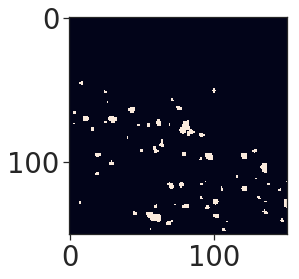

In [57]:
plt.imshow(homer_icy_mask)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

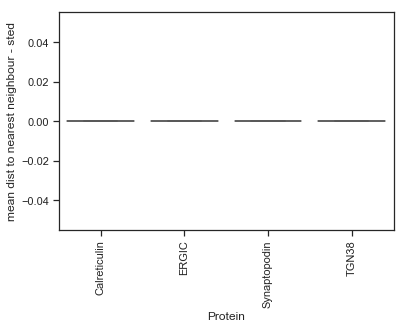

In [73]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
sns.boxplot(x="Protein",y="mean dist to nearest neighbour - sted",data=df2)
plt.xticks(rotation=90)


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

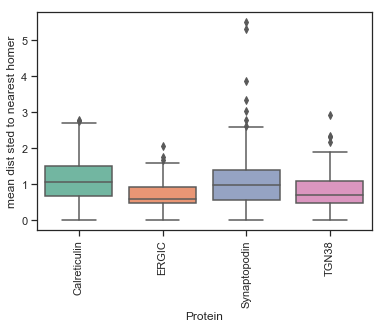

In [74]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
sns.boxplot(x="Protein",y="mean dist sted to nearest homer",data=df2)
plt.xticks(rotation=90)



## Read icy spots from scratch

In [ ]:
#make synapse results dictionary

spots={"filename":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if filelist[i].endswith(".txt"): 
        #if ("samecellonly" in str(filelist[i]))==False:
            if ("output_classification" in str(filelist[i]))==True:
                #if (protein in str(filelist[i]))==True:
                     if ("backup" in str(filelist[i]))==False:
                        #if str(filelist[i][:-12]) not in str(spots["filename"]):
                            spots["filename"].append(filelist[i])


synapses_results={"spots classification filename":[],
                "sted spot":[],
                "vglut spot":[],
                "dio spot":[],
                "sted spot aligned":[],
                  "sted spot aligned filename":[],
                "vglut spot aligned":[],
                   "vglut spot aligned filename":[],
                "dio spot aligned":[],
                 "sted spot aligned no back":[],
                "vglut spot aligned no back":[],
                "dio spot aligned no back":[],
                "Exp name":[],
                "Cell number":[],
                "unique id (expname_cell number)":[],
                "classification":[],
                  "mean ecm intensity sted":[],
                  "ecm intensity sted, bg subtracted":[],
                  "mean ecm intensity sted noback":[],
                  "ecm intensity sted noback bg subtracted":[],
                  "mean vglut intensity sted":[],
                  "vglut intensity sted, bg subtracted":[],
                  "mean vglut intensity sted noback":[],
                  "vglut intensity sted noback bg subtracted":[],
                  "mean vglut size (sum of pixels)":[],
                  "mean vglut size (sum of pixels) from noback":[],
                  "exp condition":[],
                 "dio intensity sted, bg subtracted":[]}
                  
num=0
for spot in range(0,len(spots["filename"])):
    num+=1
    print(spots["filename"][spot])
    firstpart='/'.join(spots["filename"][spot].split("/")[:-1])
    lastpart=spots["filename"][spot].split("classification")[-1]
    synapses_results["spots classification filename"].append(spots["filename"][spot])
    file2read=firstpart+'/output_sted_'+lastpart
    synapses_results["sted spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_'+lastpart
    synapses_results["vglut spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_'+lastpart
    synapses_results["dio spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    file2read=firstpart+'/output_sted_aligned_'+lastpart
    synapses_results["sted spot aligned filename"].append(file2read)
    synapses_results["sted spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    file2read=firstpart+'/output_homer_aligned_'+lastpart
    synapses_results["vglut spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    synapses_results["vglut spot aligned filename"].append(file2read)
    
    file2read=firstpart+'/output_dio_aligned_'+lastpart
    synapses_results["dio spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_noback_'+lastpart
    synapses_results["sted spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_noback_'+lastpart
    synapses_results["vglut spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_noback_'+lastpart
    synapses_results["dio spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    synapses_results["Exp name"].append(file2read.split("2019")[-1][0:4])
    synapses_results["Cell number"].append(lastpart[-9:-4])
    synapses_results["unique id (expname_cell number)"].append(file2read.split("2019")[-1][0:4]+'_'+lastpart[-9:-4])
    synapses_results["classification"].append(np.loadtxt(spots["filename"][spot]))
    synapses_results["exp condition"].append(synapses_results["spots classification filename"][spot].split("TIFs")[-1].split('/')[1])
    
    synapses_results["mean ecm intensity sted"].append(np.nan)
    
    synapses_results["ecm intensity sted, bg subtracted"].append(np.nan)
    
    synapses_results["mean ecm intensity sted noback"].append(np.nan)
    synapses_results["ecm intensity sted noback bg subtracted"].append(np.nan)
    
    synapses_results["mean vglut intensity sted"].append(np.nan)
    synapses_results["vglut intensity sted, bg subtracted"].append(np.nan)
    
    synapses_results["mean vglut intensity sted noback"].append(np.nan)
    synapses_results["vglut intensity sted noback bg subtracted"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels)"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels) from noback"].append(np.nan)
    
    synapses_results["dio intensity sted, bg subtracted"].append(np.nan)
    
clear_output() 

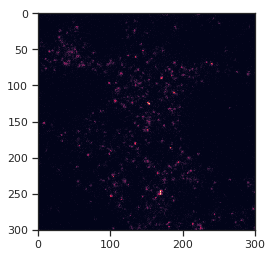

In [60]:
plt.imshow(a[:,602:])

## Make spots files for other image channels (vglut/syt)

In [315]:
df2["spots classification filename"][0]

'/Volumes/ukps-all$/user/tdanko/Imaging/03_Collab/2020_Clara/All files/N1_HPN20DIV/SYT1/Calreticulin/output_classification1_10.txt'